## COVID Information Detection  

As **COVID-19** continues to spread across the country and the world, we all must remain vigilant. The changes we have had to make to routines and daily life are extremely hard, but these changes are even more important now and in the future. We must stop the spread of this new and dangerous virus. The more steps you and your family can take to prevent the spread of COVID-19, the safer you will be.

The way this pandemic is spreading, it is creating havoc and there are certain myths and rumors related to thes disease. Sometimes a lot of information can also be misguiding. As part of an effort to **combat misinformation** about coronavirus, we are trying to classify the given dataset by binary classification, in which we will predict on the basis of the information trained, whether the information is Fake or True. This will help common citizens to identify the news related to the pandemic.

![Countries cases distribution](covid_cases.png)

Image courtesy : https://www.worldometers.info/coronavirus/worldwide-graphs/#case-distribution

### Importing libraries

In [3]:
# !pip3 install textstat
# !pip3 install lexicalrichness
# !pip3 install textblob
# !pip3 install plotly
# !pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords    
stop_words = set(stopwords.words('english'))

from nltk.tag import pos_tag
from nltk import word_tokenize
from collections import Counter

import textstat
from lexicalrichness import LexicalRichness

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


import pandas as pd
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/laxmikantbpandhare/CMPE257-Detect-Covid19-Misinformation/main/corona_fake.csv')
df

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,Fake
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,Fake
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,Fake
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,Fake
...,...,...,...,...
1159,Could the Power of the Sun Slow the Coronavirus?,A study suggests that ultraviolet rays could s...,https://www.nytimes.com/,TRUE
1160,Key evidence for coronavirus spread is flawed ...,"Last week, a medical journal reported that a b...",https://www.nytimes.com/,TRUE
1161,Summer Heat May Not Diminish Coronavirus Strength,"A new report, sent to the White House science ...",https://www.nytimes.com/,TRUE
1162,How Long Will a Vaccine Really Take?,A vaccine would be the ultimate weapon against...,https://www.nytimes.com/,TRUE


#### Dropping rows with NaN values 

In [5]:
df.isnull().values.any()

True

In [6]:
df.isnull().sum().sum()

117

In [7]:
df.dropna()

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,Fake
9,Basic protective measures against the new coro...,Stay aware of the latest information on the CO...,https://www.who.int/emergencies/diseases/novel...,TRUE
14,Exposing yourself to the sun or to temperature...,"You can catch COVID-19, no matter how sunny or...",https://www.who.int/emergencies/diseases/novel...,TRUE
16,Being able to hold your breath for 10 seconds ...,The most common symptoms of COVID-19 are dry c...,https://www.who.int/emergencies/diseases/novel...,TRUE
17,Drinking alcohol does not protect you against ...,Frequent or excessive alcohol consumption can ...,https://www.who.int/emergencies/diseases/novel...,TRUE
...,...,...,...,...
1159,Could the Power of the Sun Slow the Coronavirus?,A study suggests that ultraviolet rays could s...,https://www.nytimes.com/,TRUE
1160,Key evidence for coronavirus spread is flawed ...,"Last week, a medical journal reported that a b...",https://www.nytimes.com/,TRUE
1161,Summer Heat May Not Diminish Coronavirus Strength,"A new report, sent to the White House science ...",https://www.nytimes.com/,TRUE
1162,How Long Will a Vaccine Really Take?,A vaccine would be the ultimate weapon against...,https://www.nytimes.com/,TRUE


In [8]:
df.loc[df['label'] == 'Fake', ['label']] = 'FAKE'
df.loc[df['label'] == 'fake', ['label']] = 'FAKE'
df.loc[df['label'] == 'TRUE', ['label']] = 'GENUINE'
df.loc[df['label'] == 'True', ['label']] = 'GENUINE'
df.loc[df['source'] == 'facebook', ['source']] = 'Facebook'
df.text.fillna(df.title, inplace=True)

In [9]:
df.head(20)

,title,text,source,label
0,Due to the recent outbreak for the Coronavirus...,"You just need to add water, and the drugs and ...",coronavirusmedicalkit.com,FAKE
1,NaN,Hydroxychloroquine has been shown to have a 10...,RudyGiuliani,FAKE
2,NaN,Fact: Hydroxychloroquine has been shown to hav...,CharlieKirk,FAKE
3,NaN,The Corona virus is a man made virus created i...,JoanneWrightForCongress,FAKE
4,NaN,Doesn’t @BillGates finance research at the Wuh...,JoanneWrightForCongress,FAKE
5,CORONA UNMASKED: Chinese Intelligence Officer ...,CORONA UNMASKED: Chinese Intelligence Officer ...,NaN,NaN
6,NaN,Urgent: Health Bulletin to the Public. Ministr...,Ministry of Health,FAKE
7,NaN,"Pls tell ur families, relatives and friendsMOH...",NWLLAB,FAKE
8,NaN,SERIOUS EXCELLENT ADVICE by Japanese doctors t...,Japanese doctors treating COVID-19 cases,FAKE
9,Basic protective measures against the new coro...,Stay aware of the latest information on the CO...,https://www.who.int/emergencies/diseases/novel...,GENUINE


In [10]:
# function to remove stopwords from the text
stop_words = set(stopwords.words('english'))


def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

In [11]:
'''
Preprocess a string text input.
:parameter
    :parameter text: - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def func_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize 
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming 
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation 
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [12]:
import nltk
import re
nltk.download('wordnet')
df['text_clean'] = df['text'].apply(lambda x: func_preprocess_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [13]:
df_text_clean = df.drop("text", axis=1)
df_text_clean

,title,source,label,text_clean
0,Due to the recent outbreak for the Coronavirus...,coronavirusmedicalkit.com,FAKE,you just need to add water and the drug and va...
1,NaN,RudyGiuliani,FAKE,hydroxychloroquine ha been shown to have a 100...
2,NaN,CharlieKirk,FAKE,fact hydroxychloroquine ha been shown to have ...
3,NaN,JoanneWrightForCongress,FAKE,the corona virus is a man made virus created i...
4,NaN,JoanneWrightForCongress,FAKE,doesnt billgates finance research at the wuhan...
...,...,...,...,...
1159,Could the Power of the Sun Slow the Coronavirus?,https://www.nytimes.com/,GENUINE,a study suggests that ultraviolet ray could sl...
1160,Key evidence for coronavirus spread is flawed ...,https://www.nytimes.com/,GENUINE,last week a medical journal reported that a bu...
1161,Summer Heat May Not Diminish Coronavirus Strength,https://www.nytimes.com/,GENUINE,a new report sent to the white house science a...
1162,How Long Will a Vaccine Really Take?,https://www.nytimes.com/,GENUINE,a vaccine would be the ultimate weapon against...


In [14]:
df_text_clean = df_text_clean[['title','text_clean','source','label']]
df_text_clean.head()

,title,text_clean,source,label
0,Due to the recent outbreak for the Coronavirus...,you just need to add water and the drug and va...,coronavirusmedicalkit.com,FAKE
1,NaN,hydroxychloroquine ha been shown to have a 100...,RudyGiuliani,FAKE
2,NaN,fact hydroxychloroquine ha been shown to have ...,CharlieKirk,FAKE
3,NaN,the corona virus is a man made virus created i...,JoanneWrightForCongress,FAKE
4,NaN,doesnt billgates finance research at the wuhan...,JoanneWrightForCongress,FAKE


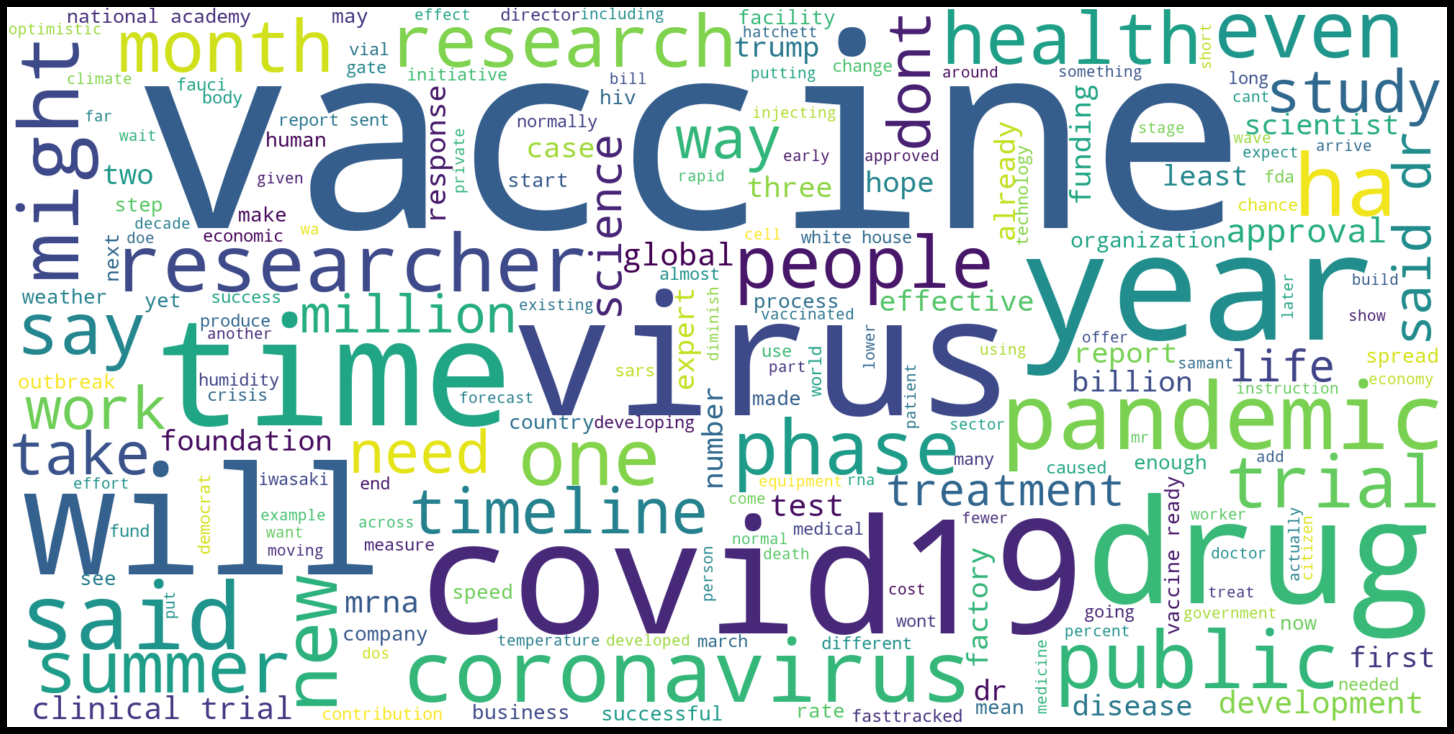

In [15]:
# # Wordcloud of corona article text
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
text = df_text_clean.text_clean.values
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (20, 15),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [16]:
df_text_clean.isnull().sum().sum()

107

In [17]:
df_text_clean=df_text_clean.dropna()
df_text_clean.head(20)

,title,text_clean,source,label
0,Due to the recent outbreak for the Coronavirus...,you just need to add water and the drug and va...,coronavirusmedicalkit.com,FAKE
9,Basic protective measures against the new coro...,stay aware of the latest information on the co...,https://www.who.int/emergencies/diseases/novel...,GENUINE
14,Exposing yourself to the sun or to temperature...,you can catch covid19 no matter how sunny or h...,https://www.who.int/emergencies/diseases/novel...,GENUINE
16,Being able to hold your breath for 10 seconds ...,the most common symptom of covid19 are dry cou...,https://www.who.int/emergencies/diseases/novel...,GENUINE
17,Drinking alcohol does not protect you against ...,frequent or excessive alcohol consumption can ...,https://www.who.int/emergencies/diseases/novel...,GENUINE
18,COVID-19 virus can be transmitted in areas wit...,from the evidence so far the covid19 virus can...,https://www.who.int/emergencies/diseases/novel...,GENUINE
19,Cold weather and snow CANNOT kill the new coro...,there is no reason to believe that cold weathe...,https://www.who.int/emergencies/diseases/novel...,GENUINE
20,Taking a hot bath does not prevent the new cor...,taking a hot bath will not prevent you from ca...,https://www.who.int/emergencies/diseases/novel...,GENUINE
21,The new coronavirus CANNOT be transmitted thro...,to date there ha been no information nor evide...,https://www.who.int/emergencies/diseases/novel...,GENUINE
22,Are hand dryers effective in killing the new c...,no hand dryer are not effective in killing the...,https://www.who.int/emergencies/diseases/novel...,GENUINE


In [18]:
df_text_clean['title_clean'] = df_text_clean['title'].apply(lambda x: func_preprocess_text(x))
final_df = df_text_clean.drop("title", axis=1)
final_df.head()

,text_clean,source,label,title_clean
0,you just need to add water and the drug and va...,coronavirusmedicalkit.com,FAKE,due to the recent outbreak for the coronavirus...
9,stay aware of the latest information on the co...,https://www.who.int/emergencies/diseases/novel...,GENUINE,basic protective measure against the new coron...
14,you can catch covid19 no matter how sunny or h...,https://www.who.int/emergencies/diseases/novel...,GENUINE,exposing yourself to the sun or to temperature...
16,the most common symptom of covid19 are dry cou...,https://www.who.int/emergencies/diseases/novel...,GENUINE,being able to hold your breath for 10 second o...
17,frequent or excessive alcohol consumption can ...,https://www.who.int/emergencies/diseases/novel...,GENUINE,drinking alcohol doe not protect you against c...


In [19]:
final_df = final_df[['title_clean','text_clean','source','label']]
final_df.head()

,title_clean,text_clean,source,label
0,due to the recent outbreak for the coronavirus...,you just need to add water and the drug and va...,coronavirusmedicalkit.com,FAKE
9,basic protective measure against the new coron...,stay aware of the latest information on the co...,https://www.who.int/emergencies/diseases/novel...,GENUINE
14,exposing yourself to the sun or to temperature...,you can catch covid19 no matter how sunny or h...,https://www.who.int/emergencies/diseases/novel...,GENUINE
16,being able to hold your breath for 10 second o...,the most common symptom of covid19 are dry cou...,https://www.who.int/emergencies/diseases/novel...,GENUINE
17,drinking alcohol doe not protect you against c...,frequent or excessive alcohol consumption can ...,https://www.who.int/emergencies/diseases/novel...,GENUINE


In [20]:
final_df.isnull().sum().sum()

0

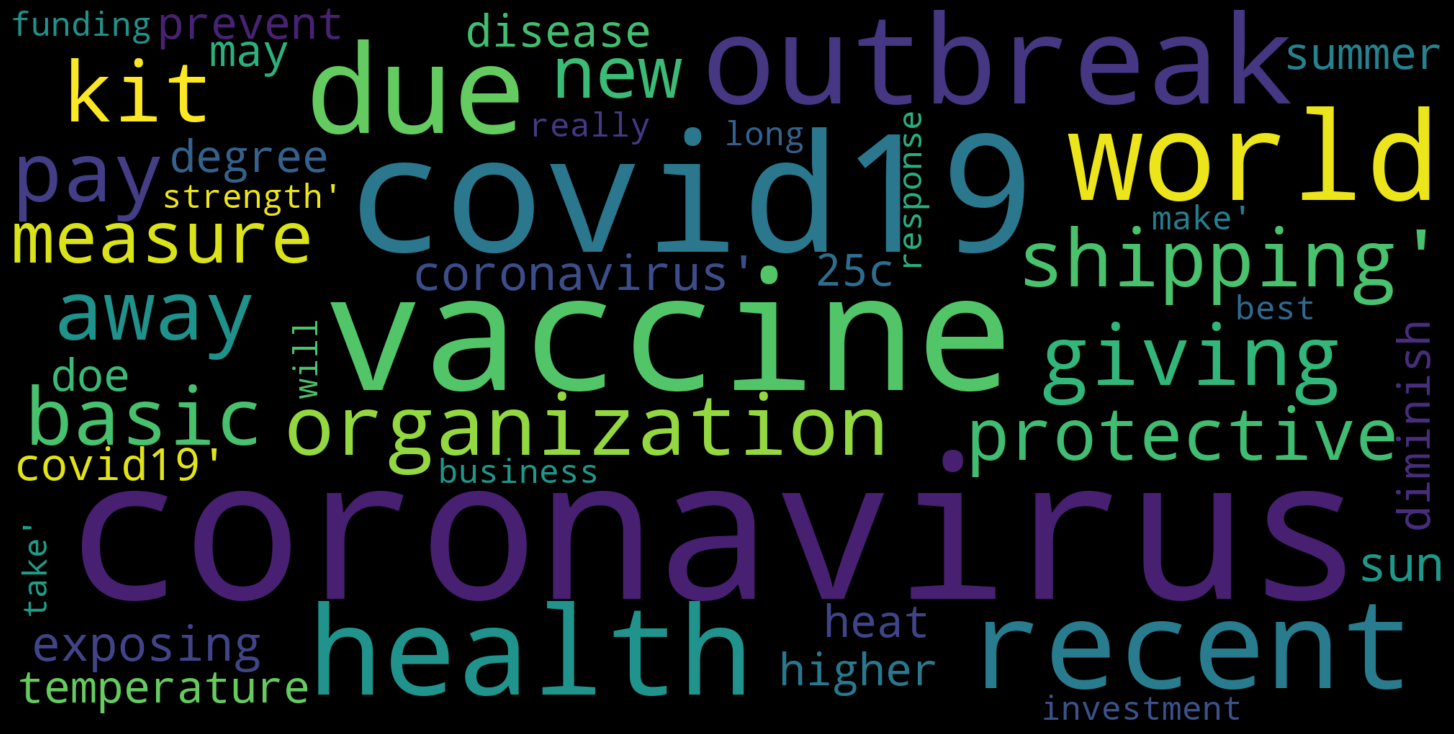

In [21]:
# Wordcloud of corona article title
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
text = final_df.title_clean.values
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (20, 15),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
# list of text documents
text = final_df['title_clean'].tolist()

# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)
# encode document
vector = vectorizer.transform([text[0]])
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

{'due': 605, 'to': 1956, 'the': 1930, 'recent': 1567, 'outbreak': 1364, 'for': 767, 'coronavirus': 417, 'covid19': 437, 'world': 2142, 'health': 892, 'organization': 1352, 'is': 1054, 'giving': 831, 'away': 161, 'vaccine': 2046, 'kit': 1090, 'just': 1078, 'pay': 1403, '495': 30, 'shipping': 1734, 'basic': 175, 'protective': 1518, 'measure': 1190, 'against': 76, 'new': 1288, 'exposing': 705, 'yourself': 2163, 'sun': 1872, 'or': 1348, 'temperature': 1917, 'higher': 912, 'than': 1926, '25c': 21, 'degree': 503, 'doe': 579, 'not': 1303, 'prevent': 1486, 'disease': 559, 'being': 193, 'able': 43, 'hold': 926, 'your': 2161, 'breath': 250, '10': 1, 'second': 1698, 'more': 1240, 'without': 2132, 'coughing': 422, 'feeling': 737, 'discomfort': 553, 'mean': 1188, 'you': 2159, 'are': 141, 'free': 784, 'from': 790, 'any': 127, 'other': 1358, 'lung': 1159, 'drinking': 598, 'alcohol': 92, 'protect': 1514, 'and': 114, 'can': 274, 'be': 179, 'dangerous': 476, 'virus': 2065, 'transmitted': 1986, 'in': 987

In [23]:
# list of text documents
text_label = final_df['label'].tolist()
# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(text_label)
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)
# encode document
vector_label = vectorizer.transform([text[0]])
# summarize encoded vector
print(vector_label.shape)
print(vector_label.toarray())

{'fake': 0, 'genuine': 1}
[1.7873344  1.60535583]
(1, 2)
[[0. 0.]]


In [24]:
final_df['label'].value_counts()

GENUINE    582
FAKE       485
Name: label, dtype: int64

In [25]:
final_df['total'] = final_df['text_clean']+' '+final_df['title_clean']
final_df['total'] = final_df['total'].str.replace('[^\w\s]','')
final_df['total'] = final_df['total'].str.lower()
final_df['total'][0]

'you just need to add water and the drug and vaccine are ready to be administered there are two part to the kit one hold pellet containing the chemical machinery that synthesis the end product and the other hold pellet containing instruction that telll the drug which compound to create mix two part together in a chosen combination add water and the treatment is ready due to the recent outbreak for the coronavirus covid19 the world health organization is giving away vaccine kit just pay 495 for shipping'

In [26]:
y=final_df.label
y

0          FAKE
9       GENUINE
14      GENUINE
16      GENUINE
17      GENUINE
         ...   
1159    GENUINE
1160    GENUINE
1161    GENUINE
1162    GENUINE
1163    GENUINE
Name: label, Length: 1067, dtype: object

In [27]:
features = final_df['total']
features

# parameter tuning usingf Grid Search CV
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import datasets, svm
import matplotlib.pyplot as plt

digits = datasets.load_digits()

digits.data[0:1]

digits.target[0:1]

# Create dataset 1
data1_features = digits.data[:1000]
data1_target = digits.target[:1000]

# Create dataset 2
data2_features = digits.data[1000:]
data2_target = digits.target[1000:]

parameter_candidates = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=svm.SVC(), param_grid=parameter_candidates, n_jobs=-1)

# Train the classifier on data1's feature and target data
clf.fit(data1_features, data1_target)   

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.1,random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(960,) (960,)
(107,) (107,)


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.80)  
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 
tfidf_test = tfidf_vectorizer.transform(X_test)


In [30]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

lsvc = LinearSVC(verbose=0)
print(lsvc)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=-1,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=False)

from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler(with_mean=False)
# scaler.fit(tfidf_train)
# tfidf_train = scaler.transform(tfidf_train)

lsvc.fit(tfidf_train, y_train)
score = lsvc.score(tfidf_train, y_train)
print("Score: ", score)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Score:  0.9989583333333333


In [31]:
cv_scores = cross_val_score(lsvc, tfidf_train, y_train, cv=10)
print("Cross-Validation average score: %.2f" % cv_scores.mean())

Cross-Validation average score: 0.93


[[43  4]
 [ 5 55]]
Classification Report for Linear SVC:
              precision    recall  f1-score   support

        FAKE       0.90      0.91      0.91        47
     GENUINE       0.93      0.92      0.92        60

    accuracy                           0.92       107
   macro avg       0.91      0.92      0.91       107
weighted avg       0.92      0.92      0.92       107

confusion matrix Linear SVC: 
 AxesSubplot(0.125,0.125;0.62x0.755)


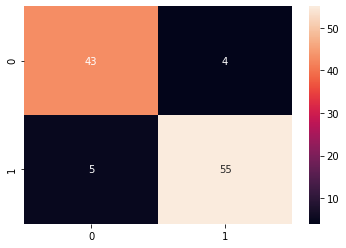

In [32]:
ypred = lsvc.predict(tfidf_test)

cm = confusion_matrix(y_test, ypred)
print(cm)

cr = classification_report(y_test, ypred)
print("Classification Report for Linear SVC:")
print(cr)

import seaborn as sns

print("confusion matrix Linear SVC: \n", sns.heatmap(cm, annot = True))